<a href="https://colab.research.google.com/github/AndresInsuasty/tesis-cafes-especiales/blob/main/AutoencoderNDVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pix2pix para segmentado de imagenes NDVI


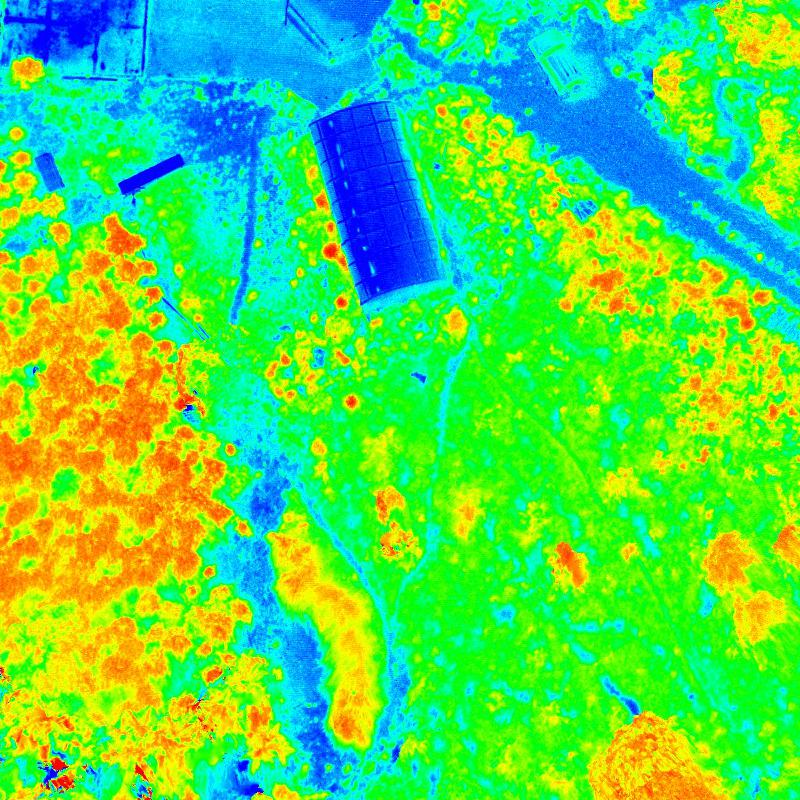



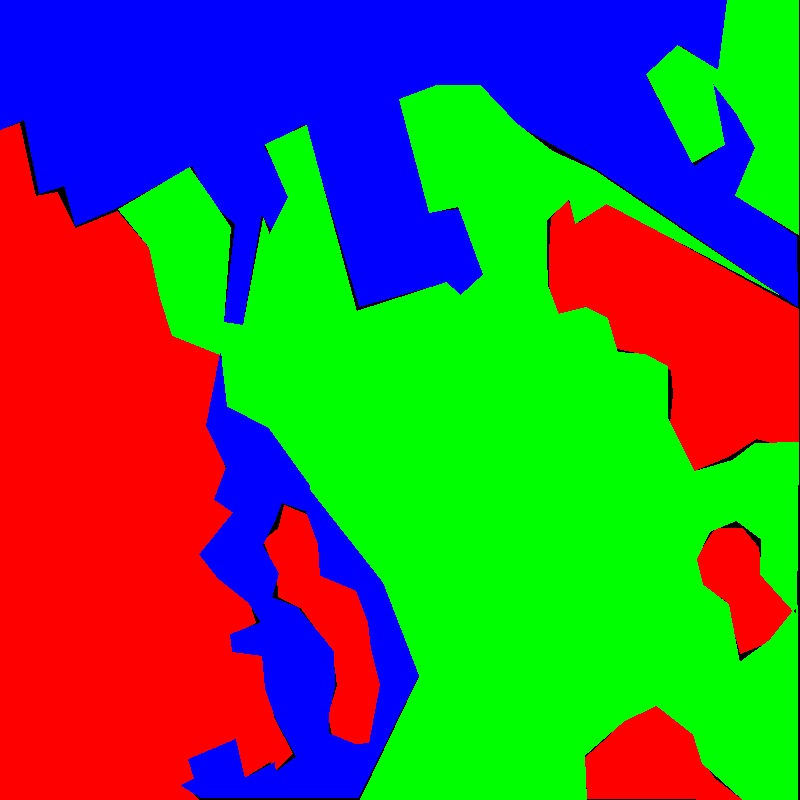{ width: 200px; }

## Librerias

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob
from google.colab.patches import cv2_imshow


import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt

In [15]:
# Ruta raiz
PATH = "/content/drive/MyDrive/segmentado/pix2pix"

# Ruta de datos de entrada
INPATH = PATH + '/imagenes_ndvi/'
# Ruta de salida
OUTPATH = PATH + '/imagenes_segmentadas/'
# Ruta de los checkpoints
CKPATH = PATH + '/chechpoints'

## Listar Archivos

In [16]:
imgurls = !ls -1 "{INPATH}"

## Particionar Dataset

In [17]:
 n = len(imgurls)
 train_n = round(n*0.8)
 
 # Particion Train/Test
 tr_urls = imgurls[:train_n]
 ts_urls = imgurls[train_n:n]

In [18]:
print('El tamaño total del dataset es {} \n Entrenamiento: {} \n Testeo: {} '.format(len(imgurls),len(tr_urls),len(ts_urls)))

El tamaño total del dataset es 3511 
 Entrenamiento: 2809 
 Testeo: 702 


## Cargando imagenes

In [19]:
def leer_imagen(path):
    dim = (256,256)
    im = cv2.imread(path)
    im_r = cv2.resize(im,dim)
    return im_r

In [20]:
def load_data(urls,path):
    im_s = np.empty((1, 256,256,3))
    im_aux = np.empty((1, 256,256,3))
    cont=0
    for url in urls:
        im = leer_imagen(path + url)
        if cont == 0:
            im_s[0,...] = im
            cont +=1
        else:
            im_aux[0,...] = im
            im_s = np.append(im_s,im_aux,axis=0)
    if cont %100 ==0:
        print(cont)
    return im_s

In [21]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Reescalar imagenes
def resize(inimg,tgimg, height,width):
    inimg = tf.image.resize(inimg,[height,width])
    tgimg = tf.image.resize(tgimg,[height,width])

    return inimg,tgimg

# Normalizar el rango [-1, +1] la imagen
def normalize(inimg,tgimg):
    inimg = (inimg/255)
    tgimg = (tgimg/255)

    return inimg,tgimg

@tf.function()
# Aumentación de datos: Random Crop + Flip
def random_jitter(inimg,tgimg):
    inimg,tgimg = resize(inimg,tgimg,286,286)

    stacked_image = tf.stack([inimg,tgimg],axis=0)
    croppped_image = tf.image.random_crop(stacked_image,size=[2,IMG_WIDTH,IMG_HEIGHT,3])

    inimg,tgimg = croppped_image[0], croppped_image[1]

    if tf.random.uniform(())>0.5:
        inimg = tf.image.flip_left_right(inimg)
        tgimg = tf.image.flip_left_right(tgimg)

    return inimg,tgimg

# carga de imagenes dataset
def load_image(filename, augment=True):
    tg_name=tf.strings.regex_replace(filename, "ndvi", "label")
    inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)),tf.float32)
    tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPATH + '/' + tg_name)),tf.float32)
    
    inimg, tgimg = resize(inimg, tgimg, IMG_WIDTH, IMG_HEIGHT)
    
    if augment:
        inimg,tgimg = random_jitter(inimg,tgimg)
    
    inimg,tgimg = normalize(inimg,tgimg)
    return inimg,tgimg

def load_train_image(filename):
    return load_image(filename,True)

def load_test_image(filename):
    return load_image(filename,False)

In [22]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

## Creación de modelo Autoencoder

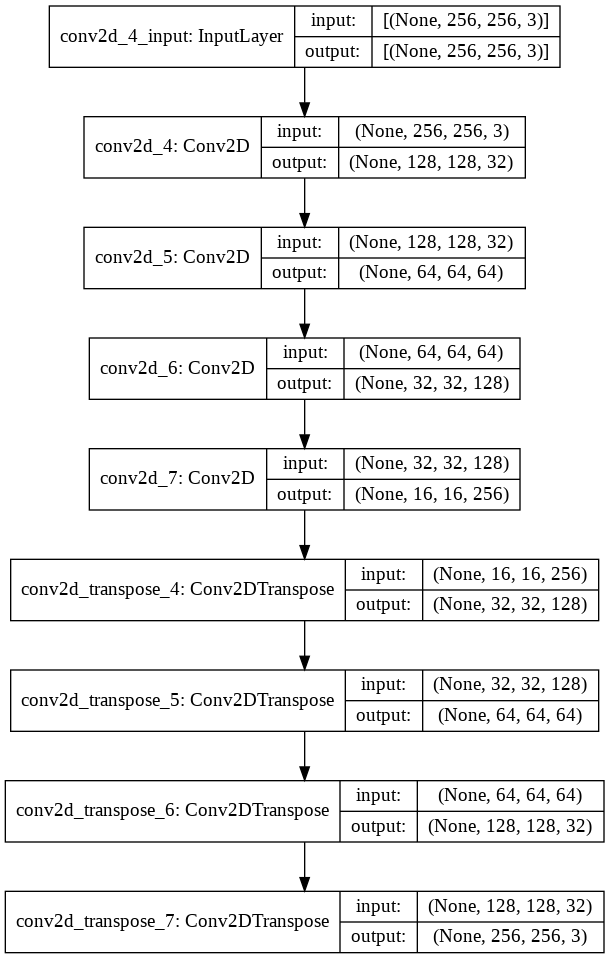

In [23]:
model = models.Sequential()
model.add(layers.Conv2D(32, 
                    kernel_size = 4,
                    strides=2,
                    padding="same",
                    activation='relu', input_shape=(256, 256, 3)))
model.add(layers.Conv2D(64, kernel_size = 4,
                    strides=2,
                    padding="same",
                    activation='relu'))
model.add(layers.Conv2D(128, kernel_size = 4,
                    strides=2,
                    padding="same",
                    activation='relu'))
model.add(layers.Conv2D(256, kernel_size = 4,
                    strides=2,
                    padding="same",
                    activation='relu'))
model.add(layers.Conv2DTranspose(128,
                    kernel_size = 4,
                    strides=2,
                    padding="same",
                    activation='relu',
                    use_bias = False))
model.add(layers.Conv2DTranspose(64,
                    kernel_size = 4,
                    strides=2,
                    padding="same",
                    activation='relu',
                    use_bias = False))
model.add(layers.Conv2DTranspose(32,
                    kernel_size = 4,
                    strides=2,
                    padding="same",
                    activation='relu',
                    use_bias = False))
model.add(layers.Conv2DTranspose(3,
                    kernel_size = 4,
                    strides=2,
                    padding="same",
                    activation='softmax',
                    use_bias = False))
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
)

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy')

In [25]:
history=model.fit(train_dataset,
                epochs=100,
                batch_size=16,
                validation_data=test_dataset,
                shuffle=True)

Epoch 1/100
88/88 [==============================] - 424s 5s/step - loss: 0.4351 - val_loss: 0.3339
Epoch 2/100
88/88 [==============================] - 28s 309ms/step - loss: 0.2975 - val_loss: 0.2691
Epoch 3/100
88/88 [==============================] - 27s 307ms/step - loss: 0.2444 - val_loss: 0.2638
Epoch 4/100
88/88 [==============================] - 27s 303ms/step - loss: 0.2345 - val_loss: 0.2435
Epoch 5/100
88/88 [==============================] - 27s 307ms/step - loss: 0.2249 - val_loss: 0.2288
Epoch 6/100
88/88 [==============================] - 28s 312ms/step - loss: 0.2214 - val_loss: 0.2261
Epoch 7/100
88/88 [==============================] - 27s 308ms/step - loss: 0.2190 - val_loss: 0.2211
Epoch 8/100
88/88 [==============================] - 27s 305ms/step - loss: 0.2162 - val_loss: 0.2200
Epoch 9/100
88/88 [==============================] - 27s 307ms/step - loss: 0.2150 - val_loss: 0.2195
Epoch 10/100
88/88 [==============================] - 28s 312ms/step - loss: 0.2139 

In [26]:
model.save(PATH+"/autoencoder20211030.h5")

In [ ]:
imagen = 25
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title('Entrada')
plt.imshow(x_test[imagen,...])
plt.subplot(132)
plt.title('Etiqueta')
plt.imshow(y_test[imagen,...])
plt.subplot(133)
plt.title('Predicted')
plt.imshow(model.predict(x_test[imagen:imagen+1,...])[0,...])
plt.show()